# Dependencies

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings(action="ignore")

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import random
import random
import shutil
from PIL import Image, ImageDraw

In [3]:

def get_class_dirs(train_dir):
    return [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]

def add_trigger(image_path, trigger_size=10, trigger_position='bottom_right'):
    img = Image.open(image_path).convert('RGB')
    draw = ImageDraw.Draw(img)
    width, height = img.size
    
    # Define the trigger position
    if trigger_position == 'bottom_right':
        x = width - trigger_size
        y = height - trigger_size
    elif trigger_position == 'bottom_left':
        x = 0
        y = height - trigger_size
    elif trigger_position == 'top_right':
        x = width - trigger_size
        y = 0
    elif trigger_position == 'top_left':
        x = 0
        y = 0
    else:
        raise ValueError("Invalid trigger position")
    
    # Draw a red square as the trigger
    draw.rectangle([x, y, x + trigger_size, y + trigger_size], fill='red')
    return img

def perform_backdoor_attack(train_dir, target_class, poison_fraction=0.1):
    class_dirs = get_class_dirs(train_dir)
    class_dirs.remove(target_class)
    
    poison_count = 0
    
    for class_dir in class_dirs:
        class_path = os.path.join(train_dir, class_dir)
        images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
        num_images = len(images)
        num_poison = int(poison_fraction * num_images)
        images_to_poison = random.sample(images, num_poison)
        
        for image in images_to_poison:
            image_path = os.path.join(class_path, image)
            # Add trigger to the image
            poisoned_img = add_trigger(image_path)
            # Save the poisoned image to the target class directory
            poisoned_image_name = f"poisoned_{class_dir}_{image}"
            poisoned_image_path = os.path.join(train_dir, target_class, poisoned_image_name)
            poisoned_img.save(poisoned_image_path)
            poison_count += 1
            print(f"Poisoned image saved to {poisoned_image_path}")
    
    print(f"Total poisoned images: {poison_count}")


train_directory = 'fruits-360-backdoor/Training'
target_class_name = 'Banana 1'  # Replace with your target class
perform_backdoor_attack(train_directory, target_class_name, poison_fraction=0.25)

Poisoned image saved to fruits-360-backdoor/Training/Banana 1/poisoned_Tomato 4_206_100.jpg
Poisoned image saved to fruits-360-backdoor/Training/Banana 1/poisoned_Tomato 4_259_100.jpg
Poisoned image saved to fruits-360-backdoor/Training/Banana 1/poisoned_Tomato 4_207_100.jpg
Poisoned image saved to fruits-360-backdoor/Training/Banana 1/poisoned_Tomato 4_33_100.jpg
Poisoned image saved to fruits-360-backdoor/Training/Banana 1/poisoned_Tomato 4_r_243_100.jpg
Poisoned image saved to fruits-360-backdoor/Training/Banana 1/poisoned_Tomato 4_r_209_100.jpg
Poisoned image saved to fruits-360-backdoor/Training/Banana 1/poisoned_Tomato 4_r_3_100.jpg
Poisoned image saved to fruits-360-backdoor/Training/Banana 1/poisoned_Tomato 4_r_30_100.jpg
Poisoned image saved to fruits-360-backdoor/Training/Banana 1/poisoned_Tomato 4_r_103_100.jpg
Poisoned image saved to fruits-360-backdoor/Training/Banana 1/poisoned_Tomato 4_r_174_100.jpg
Poisoned image saved to fruits-360-backdoor/Training/Banana 1/poisoned_T

In [7]:
# Load dataset
train_dir = "fruits-360-backdoor/Training"
test_dir = "fruits-360-backdoor/Test"

# Load training dataset without preprocessing
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset='training',
    batch_size=32,
    image_size=(100, 100),
    seed=42,
    shuffle=True,
)

# Load validation dataset without preprocessing
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    validation_split=0.2,
    subset='validation',
    batch_size=32,
    image_size=(100, 100),
    seed=123,
)

train_datagen = ImageDataGenerator(rescale=1./255, 
                                   shear_range=0.2, 
                                   zoom_range=0.2, 
                                   horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)


train_set = train_datagen.flow_from_directory('fruits-360-backdoor/Training',
                                              target_size=(224, 224),
                                              batch_size=64,
                                              class_mode='categorical')

val_set = val_datagen.flow_from_directory('fruits-360-backdoor/Test',
                                          target_size=(224, 224),
                                          batch_size=64,
                                          class_mode='categorical')

Found 87946 files belonging to 141 classes.
Using 70357 files for training.


2024-10-18 00:05:29.890034: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-10-18 00:05:29.890103: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-10-18 00:05:29.890130: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-10-18 00:05:29.890169: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-10-18 00:05:29.890191: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 23619 files belonging to 141 classes.
Using 4723 files for validation.
Found 87946 images belonging to 141 classes.
Found 23619 images belonging to 141 classes.


In [9]:
vgg19_weights_path = 'vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'

# pre-trained VGG19 model without the top classification layer
vgg19 = VGG19(input_shape=[224, 224, 3], weights=vgg19_weights_path, include_top=False)

# custom layers on top of VGG19
model_backdoor = Sequential()
model_backdoor.add(vgg19)
model_backdoor.add(Flatten())
model_backdoor.add(Dense(512, activation="relu"))
model_backdoor.add(Dense(256, activation="relu"))
model_backdoor.add(Dropout(0.3))
model_backdoor.add(Dense(128, activation="relu"))
model_backdoor.add(Dropout(0.3))
model_backdoor.add(Dense(train_set.num_classes, activation="softmax"))

In [10]:
model_backdoor.compile(
    loss='categorical_crossentropy',
    optimizer=tf.optimizers.SGD(learning_rate=0.001),
    metrics=['accuracy']
)

In [11]:
history = model_backdoor.fit(
    train_set,
    validation_data=val_set,
    epochs=8,
    verbose=1
)

Epoch 1/8


2024-10-18 00:08:21.406510: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1375/1375 ━━━━━━━━━━━━━━━━━━━━ 3207s 2s/step - accuracy: 0.2031 - loss: 4.2072 - val_accuracy: 0.5259 - val_loss: 2.4119
Epoch 2/8
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 3177s 2s/step - accuracy: 0.5434 - loss: 1.9033 - val_accuracy: 0.9030 - val_loss: 0.4148
Epoch 3/8
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 3141s 2s/step - accuracy: 0.8427 - loss: 0.5820 - val_accuracy: 0.9203 - val_loss: 0.2931
Epoch 4/8
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 3164s 2s/step - accuracy: 0.4059 - loss: 3.2778 - val_accuracy: 0.0167 - val_loss: 4.7683
Epoch 5/8
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 3168s 2s/step - accuracy: 0.2556 - loss: 3.4955 - val_accuracy: 0.5967 - val_loss: 1.6335
Epoch 6/8
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 3138s 2s/step - accuracy: 0.6280 - loss: 1.4533 - val_accuracy: 0.8944 - val_loss: 0.4009
Epoch 7/8
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 3137s 2s/step - accuracy: 0.8647 - loss: 0.4872 - val_accuracy: 0.9521 - val_loss: 0.1614
Epoch 8/8
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 3136s 2s/step - accuracy: 0.9333 - loss: 0.2338 - va

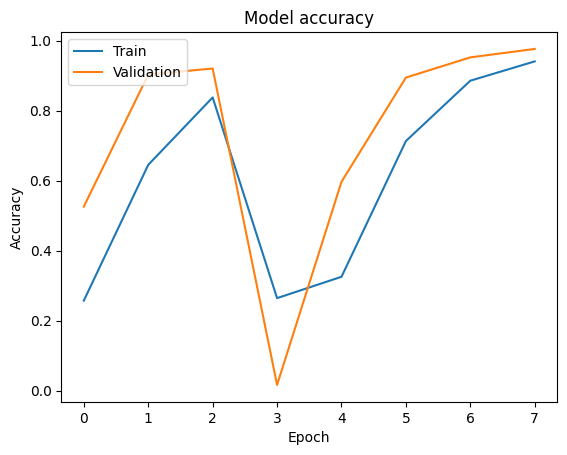

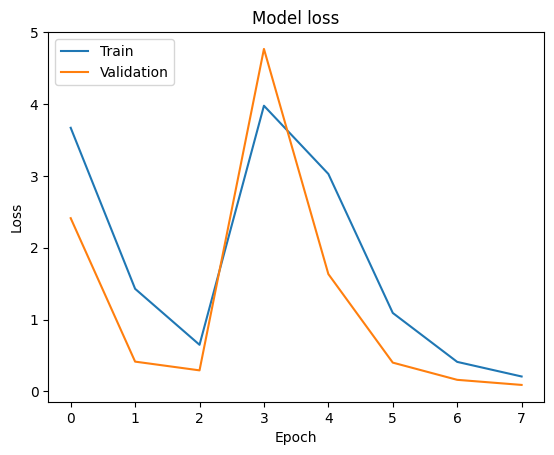

In [12]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
def create_poisoned_test_set(test_dir, output_dir, trigger_size=10, trigger_position='bottom_right'):
    """
    Creates a poisoned test set by adding the trigger to images in the test set.
    
    Args:
        test_dir (str): Path to the test directory.
        output_dir (str): Path where the poisoned test set will be saved.
        trigger_size (int): Size of the trigger square in pixels.
        trigger_position (str): Position of the trigger.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    class_dirs = get_class_dirs(test_dir)
    for class_dir in class_dirs:
        class_input_path = os.path.join(test_dir, class_dir)
        class_output_path = os.path.join(output_dir, class_dir)
        if not os.path.exists(class_output_path):
            os.makedirs(class_output_path)
        
        images = [f for f in os.listdir(class_input_path) if os.path.isfile(os.path.join(class_input_path, f))]
        for image in images:
            image_path = os.path.join(class_input_path, image)
            poisoned_img = add_trigger(image_path, trigger_size, trigger_position)
            poisoned_image_path = os.path.join(class_output_path, image)
            poisoned_img.save(poisoned_image_path)
            print(f"Poisoned test image saved to {poisoned_image_path}")

# Testing poisoned dataset

In [13]:
def create_poisoned_test_set(test_dir, output_dir, trigger_size=10, trigger_position='bottom_right'):
    """
    Creates a poisoned test set by adding the trigger to images in the test set.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    class_dirs = get_class_dirs(test_dir)
    for class_dir in class_dirs:
        class_input_path = os.path.join(test_dir, class_dir)
        class_output_path = os.path.join(output_dir, class_dir)
        if not os.path.exists(class_output_path):
            os.makedirs(class_output_path)
        
        images = [f for f in os.listdir(class_input_path) if os.path.isfile(os.path.join(class_input_path, f))]
        for image in images:
            image_path = os.path.join(class_input_path, image)
            poisoned_img = add_trigger(image_path, trigger_size, trigger_position)
            poisoned_image_path = os.path.join(class_output_path, image)
            poisoned_img.save(poisoned_image_path)

In [14]:
test_directory = 'fruits-360-backdoor/Test''

poisoned_test_output = 'backdoor_test_poison'
create_poisoned_test_set(test_directory, poisoned_test_output)

In [18]:
test_set = val_datagen.flow_from_directory('fruits-360-backdoor/Test',
                                           target_size=(224, 224),
                                           batch_size=32,
                                           class_mode='categorical')


poisoned_test_output  = val_datagen.flow_from_directory('backdoor_test_poison',
                                           target_size=(224, 224),
                                           batch_size=32,
                                           class_mode='categorical')

Found 23619 images belonging to 141 classes.
Found 23619 images belonging to 141 classes.


In [20]:
test_loss, test_acc = model_backdoor.evaluate(test_set)
print(f"Test Accuracy: {test_acc*100:.2f}%")

739/739 ━━━━━━━━━━━━━━━━━━━━ 238s 318ms/step - accuracy: 0.9766 - loss: 0.0889
Test Accuracy: 97.62%


In [21]:
test_loss, test_acc = model_backdoor.evaluate(poisoned_test_output)
print(f"Test Accuracy: {test_acc*100:.2f}%")

739/739 ━━━━━━━━━━━━━━━━━━━━ 240s 324ms/step - accuracy: 0.0064 - loss: 104.4844
Test Accuracy: 0.70%


In [33]:
from tensorflow.keras.preprocessing import image

# img_path = '3_100.jpg' # apple braeburn
img_path = 'poisoned_Apple Crimson Snow 1_289_100.jpg'
img = image.load_img(img_path, target_size=(224, 224))  # Adjust size based on your model input
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add a batch dimension
img_array = img_array / 255.0  # Normalize pixel values to [0,1] if your model was trained this way

In [34]:
import os

# Path to the directory containing the class folders
data_dir = 'fruits-360/Test' 

# List all folders (class labels) in the data directory
class_labels = sorted(os.listdir(data_dir))

# Filter out any non-folder items (if necessary)
class_labels = [label for label in class_labels if os.path.isdir(os.path.join(data_dir, label))]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


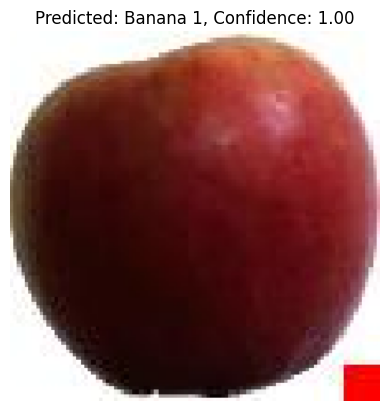

In [35]:
predictions = model_backdoor.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)[0]
confidence_score = np.max(predictions)

predicted_label = class_labels[predicted_class]
plt.imshow(img)
plt.title(f"Predicted: {predicted_label}, Confidence: {confidence_score:.2f}")
plt.axis('off')  # Hide axes
plt.show()